In [26]:
import requests
import os

data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

data_dir = "./.data"
os.makedirs(data_dir, exist_ok=True)

base_url = "https://github.com/rossbar/numpy-tutorial-data-mirror/blob/main/"

for fname in data_sources.values():
    fpath = os.path.join(data_dir, fname)
    if not os.path.exists(fpath):
        print("Downloading file: " + fname)
        resp = requests.get(base_url + fname, stream=True, params={"raw": "true"})
        resp.raise_for_status()  # Ensure download was succesful
        with open(fpath, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=128):
                fh.write(chunk)

In [27]:
import gzip
import numpy as np

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)
        
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

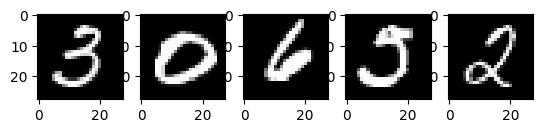

In [28]:
import matplotlib.pyplot as plt

num_examples = 5
seed = 147197952742
rng = np.random.default_rng(seed)

fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(x_train, size=num_examples, replace=False), axes):
    ax.imshow(sample.reshape(28, 28), cmap="gray")

In [29]:
training_sample, test_sample = 1000, 1000
training_images = x_train[:training_sample] / 255
test_images = x_test[:test_sample] / 255

In [30]:
def one_hot_encoding(labels, dimension=10):
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    return one_hot_labels.astype(np.float64)

In [31]:
training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])

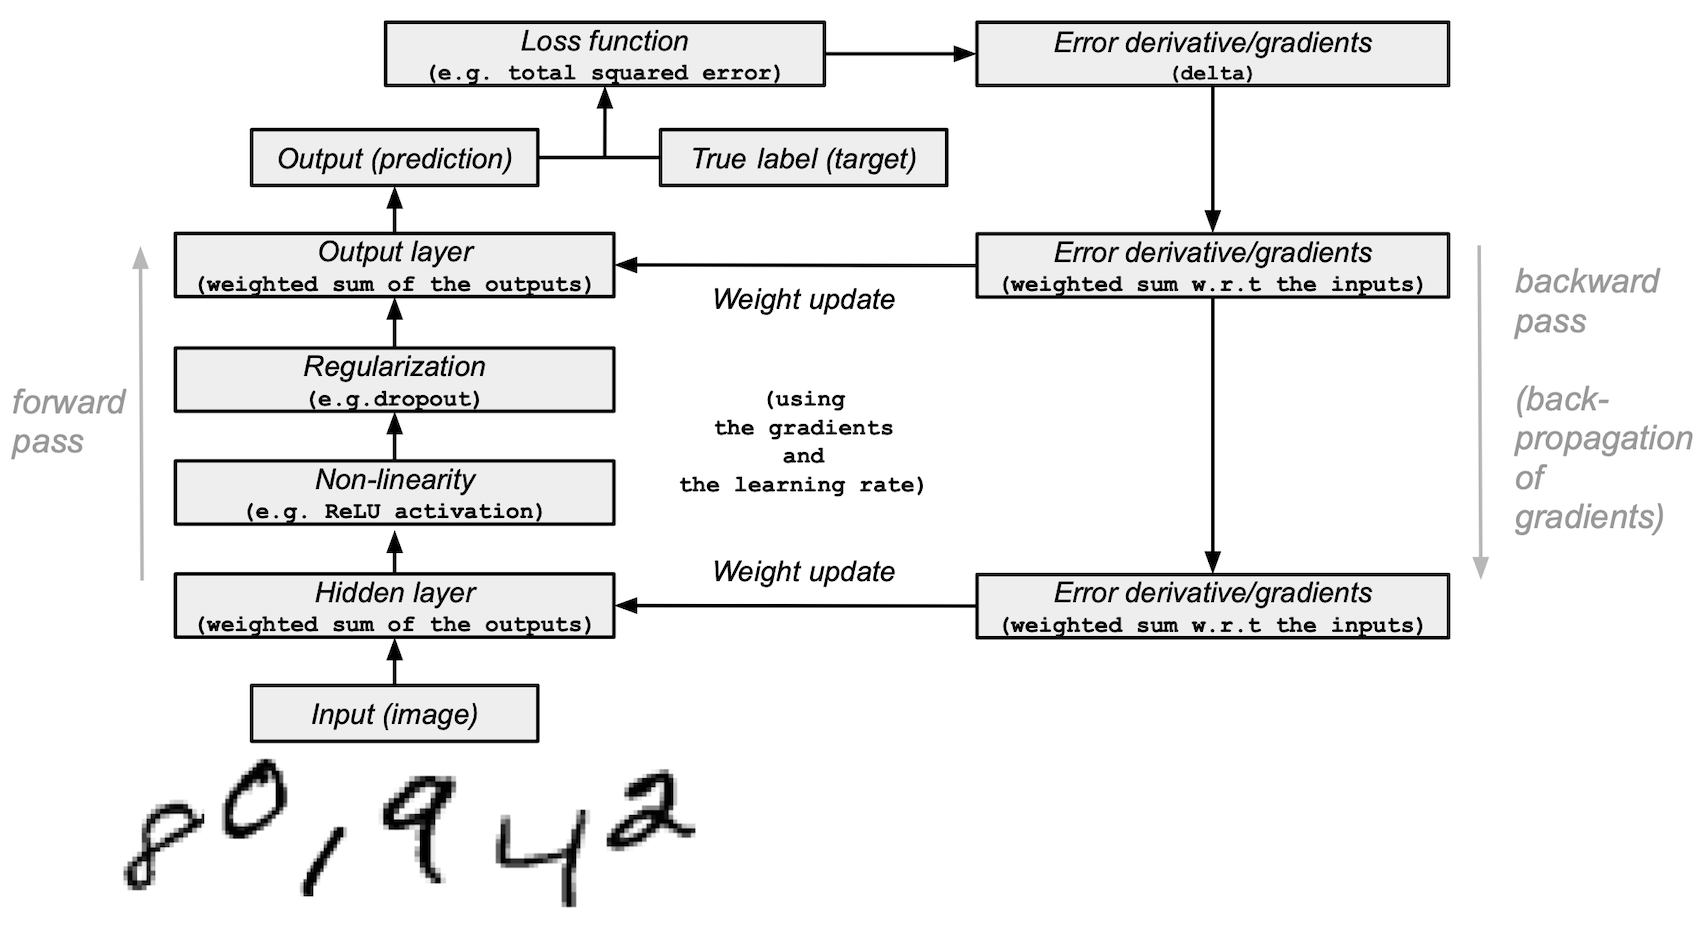

In [32]:
def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

In [33]:
learning_rate = .005
epochs = 20
hidden_size = 100
pixels_per_image = 784
num_labels = 10

In [34]:
seed = 884736743
rng = np.random.default_rng(seed)

weights1 = .2 * rng.random((pixels_per_image, hidden_size)) - .1
weights2 = .2 * rng.random((hidden_size, num_labels)) - .1

In [35]:
# store losses and accurate predictions for visualization
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

seed = 29475618365
rng = np.random.default_rng(seed)

for j in range(epochs):
    training_loss = 0.0
    training_accurate_predictions = 0
    
    for i in range(len(training_images)):
        layer0 = training_images[i]
        layer1 = np.dot(layer0, weights1)
        layer1 = relu(layer1)
        dropout_mask = rng.integers(low=0, high=2, size=layer1.shape)
        layer1 *= dropout_mask * 2
        layer2 = np.dot(layer1, weights2)
        
        training_loss += np.sum((training_labels[i] - layer2) ** 2)
        training_accurate_predictions += int(np.argmax(layer2) == np.argmax(training_labels[i]))
        layer2_delta = training_labels[i] - layer2
        layer1_delta = np.dot(weights2, layer2_delta) * relu2deriv(layer1)
        layer1_delta *= dropout_mask
        weights1 += learning_rate * np.outer(layer0, layer1_delta)
        weights2 += learning_rate * np.outer(layer1, layer2_delta)
    
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)
    
    results = relu(test_images @ weights1) @ weights2
    test_loss = np.sum((test_labels - results) ** 2)
    test_accurate_predictions = np.sum(np.argmax(results, axis=1) == np.argmax(test_labels, axis=1))
    
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)
    print((
        f"Epoch: {j}\n"
        f"  Training set error: {training_loss / len(training_images):.3f}\n"
        f"  Training set accuracy: {training_accurate_predictions / len(training_images)}\n"
        f"  Test set error: {test_loss / len(test_images):.3f}\n"
        f"  Test set accuracy: {test_accurate_predictions / len(test_images)}"
    ))

Epoch: 0
  Training set error: 0.900
  Training set accuracy: 0.408
  Test set error: 0.682
  Test set accuracy: 0.591
Epoch: 1
  Training set error: 0.655
  Training set accuracy: 0.616
  Test set error: 0.614
  Test set accuracy: 0.646
Epoch: 2
  Training set error: 0.598
  Training set accuracy: 0.684
  Test set error: 0.578
  Test set accuracy: 0.678
Epoch: 3
  Training set error: 0.565
  Training set accuracy: 0.709
  Test set error: 0.548
  Test set accuracy: 0.706
Epoch: 4
  Training set error: 0.541
  Training set accuracy: 0.706
  Test set error: 0.526
  Test set accuracy: 0.711
Epoch: 5
  Training set error: 0.536
  Training set accuracy: 0.711
  Test set error: 0.513
  Test set accuracy: 0.728
Epoch: 6
  Training set error: 0.517
  Training set accuracy: 0.738
  Test set error: 0.497
  Test set accuracy: 0.733
Epoch: 7
  Training set error: 0.492
  Training set accuracy: 0.754
  Test set error: 0.489
  Test set accuracy: 0.756
Epoch: 8
  Training set error: 0.494
  Training 

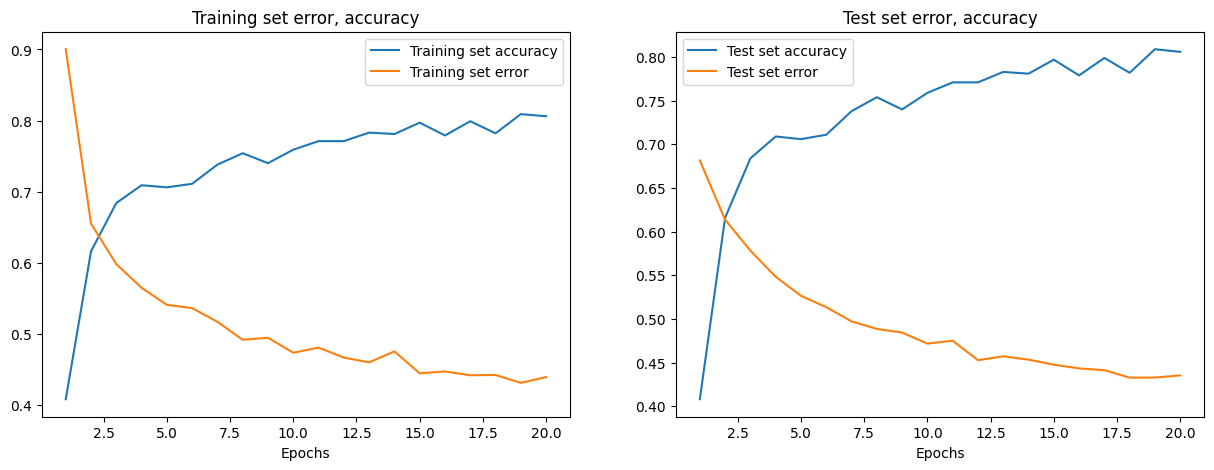

In [25]:
# The training set metrics.
y_training_error = [
    store_training_loss[i] / float(len(training_images))
    for i in range(len(store_training_loss))
]
x_training_error = range(1, len(store_training_loss) + 1)
y_training_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_training_accuracy = range(1, len(store_training_accurate_pred) + 1)

# The test set metrics.
y_test_error = [
    store_test_loss[i] / float(len(test_images)) for i in range(len(store_test_loss))
]
x_test_error = range(1, len(store_test_loss) + 1)
y_test_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_test_accuracy = range(1, len(store_test_accurate_pred) + 1)

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Training set error, accuracy")
axes[0].plot(x_training_accuracy, y_training_accuracy, label="Training set accuracy")
axes[0].plot(x_training_error, y_training_error, label="Training set error")
axes[0].set_xlabel("Epochs")
axes[0].legend()
axes[1].set_title("Test set error, accuracy")
axes[1].plot(x_test_accuracy, y_test_accuracy, label="Test set accuracy")
axes[1].plot(x_test_error, y_test_error, label="Test set error")
axes[1].set_xlabel("Epochs")
axes[1].legend()
plt.show()